# Toy Experiments

In [1]:
import torch
import torch.distributions as td

from sklearn.datasets import make_blobs, make_swiss_roll
import math

from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Hyper-parameters

In [17]:
MU_Y = 0.
MU_Z = 0.
X_LOC_START = 0.
X_LOC_FINISH = 6.
NUM_STEPS = 20
LR = 0.15

## 1. Data

In [18]:
class TwoDimStackedGauss:
    
    def __init__(self, mu_y, mu_z, x_loc, cov=None):
        
        self.x_loc = x_loc
        self.mu = torch.tensor([mu_y, mu_z])
        self.cov = torch.eye(len(self.mu)) if cov == None else cov
        self.dist = td.MultivariateNormal(loc = self.mu, 
                                          covariance_matrix = self.cov)
        
        
    def sample(self,size):
        sample = self.dist.sample(torch.tensor([size]))
        stack_dim = torch.tensor([self.x_loc]*size).unsqueeze(dim=-1)
        return torch.cat([stack_dim, sample],dim=1)

In [19]:
class Sampler:
    def __init__(
        self, device='cpu',
    ):
        self.device = device
    
    def sample(self, size=5):
        pass

In [20]:
class SwissRollSampler(Sampler):
    def __init__(
        self, x_loc, dim=2,  device='cpu'
    ):
        super(SwissRollSampler, self).__init__(device=device)
        assert dim == 2
        self.dim = 2
        self.x_loc = x_loc
        
    def sample(self, batch_size=10):
        batch =  make_swiss_roll(
            n_samples=batch_size,
            noise=0.8
        )[0].astype('float32')[:, [0, 2]] / 5.
        x=torch.tensor(batch, device=self.device).cpu()
        stack_dim = torch.tensor([self.x_loc]* batch.shape[0]).unsqueeze(dim=-1)
        return  torch.cat([stack_dim,x],dim=1).to('cpu')

In [21]:
p_dist =  TwoDimStackedGauss(mu_y=MU_Y, mu_z=MU_Z, x_loc=X_LOC_START)
q_dist =  SwissRollSampler(x_loc=X_LOC_FINISH, dim=2,)

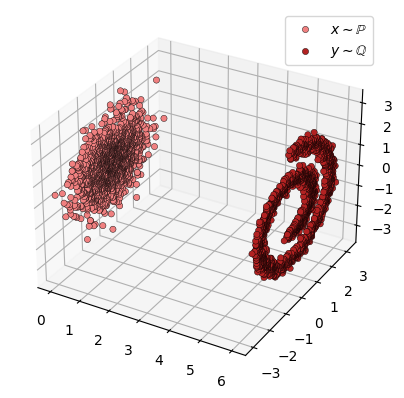

In [22]:
p_sample = p_dist.sample(2000)
q_sample = q_dist.sample(2000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
 
xs = p_sample[:,0] 
ys = p_sample[:,1]
zs = p_sample[:,2]
ax.scatter(xs, ys, zs,color='lightcoral',label=r'$x \sim \mathbb{P}$', edgecolor='black', alpha=1, linewidth=0.3)

xs = q_sample[:,0] 
ys = q_sample[:,1]
zs = q_sample[:,2]
ax.scatter(xs, ys, zs, color='firebrick',label=r'$y \sim \mathbb{Q}$', edgecolor='black',alpha=1, linewidth=0.3)
plt.legend()
plt.show()

## 2. Electrostatic General field

$$ E(x) = - \nabla_{x} \phi(x) =  \mathbb{E}_{\rho(y)} \frac{1}{S_{2}(1)}\frac{x-y}{||x-y||^{3}}$$

In [23]:
def compute_field(x, p_sample, q_sample):
    
    
    gt_distance_x = torch.norm((x.unsqueeze(1) - p_sample),dim=-1) # [B,1000]
    distance_x = 1/ (gt_distance_x + 1e-7 )
    distance_x = distance_x ** 3
    distance_x = distance_x[:, :, None] # [B,1000,1]
   
    
    
    gt_distance_y = torch.norm((x.unsqueeze(1) - q_sample),dim=-1) # [B,1000]
    distance_y = 1/ (gt_distance_y + 1e-7)
    distance_y = distance_y ** 3
    distance_y = distance_y[:, :, None] # [B,1000,1]
     
    
    
    coeff_x = distance_x / (torch.sum(distance_x, dim=1, keepdim=True)  )
    coeff_y = distance_y / (torch.sum(distance_y, dim=1, keepdim=True)  )
    
    diff_x = - (x.unsqueeze(1) - p_sample) # [B,1000,3]
    diff_y = - (x.unsqueeze(1) - q_sample) # [B,1000,3]
     
    gt_direction_x = torch.sum(coeff_x * diff_x, dim=1)
    gt_direction_x = gt_direction_x.view(gt_direction_x.size(0), -1)

    gt_direction_y = torch.sum(coeff_y * diff_y, dim=1)
    gt_direction_y = gt_direction_y.view(gt_direction_y.size(0), -1)

    
    gt_norm_x = gt_direction_x.norm(p=2, dim=-1)
    # Normalizing the N+1-dimensional Poisson field
    gt_direction_x /= (gt_norm_x.view(-1, 1) )
    gt_direction_x *= np.sqrt(3)
    
    gt_norm_y = gt_direction_y.norm(p=2, dim=-1)
    # Normalizing the N+1-dimensional Poisson field
    gt_direction_y /= (gt_norm_y.view(-1, 1) )
    gt_direction_y *= np.sqrt(3)
    
    
    return  gt_direction_x -  gt_direction_y

## 3. Euler ODE along trajectory

In [35]:
class EulerSolver:
    
    def __init__(self, num_steps, lr, p_sample, q_sample):
        self.num_steps = num_steps
        self.p_sample = p_sample
        self.q_sample = q_sample
        self.lr = lr
    
    def __call__(self, x_init):
        """
        x_init - torch.size([B,3])
        """

        trajectory = [x_init]
        field = torch.zeros(x_init.shape[0],3)
        for step in range(self.num_steps):
            
            mask = x_init[:,0] <= 6.
            
            if len(x_init[mask]) != 0:
                field[mask] = compute_field(x_init[mask].data, self.p_sample, self.q_sample)
            field[~mask] = 0
            
            x_init = x_init - self.lr*field 
 
            trajectory.append(x_init)
    
         
        return x_init, trajectory

In [36]:
solver = EulerSolver(NUM_STEPS,  LR, p_sample, q_sample)
x =  p_sample
mapped, traj = solver(x)
traj = torch.stack(traj,dim=0)

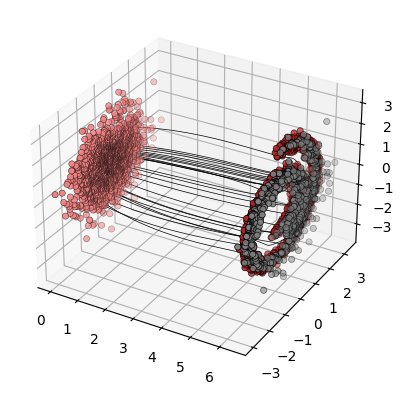

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = p_sample[:,0] 
ys = p_sample[:,1]
zs = p_sample[:,2]
ax.scatter(xs, ys, zs,color='lightcoral',label=r'$x \sim \mathbb{P}$', edgecolor='black', linewidth=0.3)


xs = q_sample[:,0] 
ys = q_sample[:,1]
zs = q_sample[:,2]
ax.scatter(xs, ys, zs,color='firebrick',label=r'$y \sim \mathbb{Q}$', edgecolor='black', linewidth=0.5)


xs = mapped[:,0] 
ys = mapped[:,1]
zs = mapped[:,2]
ax.scatter(xs, ys, zs,color='gray',label=r'$\hat{x} = T(x)$',edgecolor='black', linewidth=0.5)


for idx in range(25):
    ax.plot(traj[:,idx,0],traj[:,idx,1],traj[:,idx,2], color='black',linewidth=0.5);
    
#plt.legend(loc='lower right')
#fig.savefig("pics/3d.png",transparent=True)
plt.show()

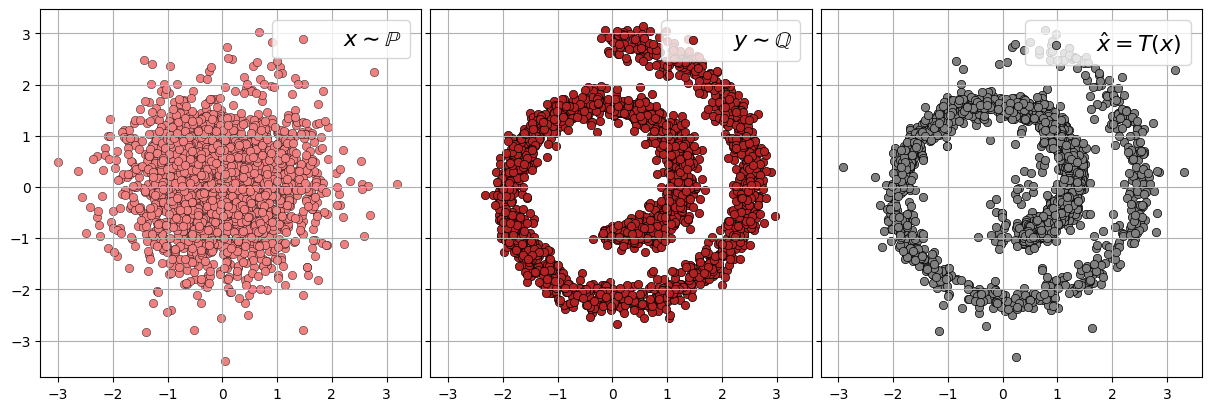

In [41]:
fig,ax = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)
ax[0].scatter(p_sample[:,1],p_sample[:,2],
              color='lightcoral',label=r'$x \sim \mathbb{P}$', edgecolor='black', linewidth=0.3)
 
ax[1].scatter(q_sample[:,1],q_sample[:,2],
             color='firebrick',label=r'$y \sim \mathbb{Q}$', edgecolor='black', linewidth=0.5)
ax[2].scatter(mapped[:,1]   ,
              mapped[:,2]  ,
             color='gray',label=r'$\hat{x} = T(x)$',edgecolor='black', linewidth=0.5)

for idx in range(3):
    #ax[idx].set_xticks([])
    #ax[idx].set_yticks([])
    ax[idx].legend(fontsize=16,loc="upper right")
    ax[idx].grid(True)
    
      
fig.tight_layout(pad=0.3)
#fig.savefig("pics/data.png",transparent=True)

## 3+. Adaptive Euler Solver

In [ ]:
class AdaptiveEulerSolver:
    
    def __init__(self, num_steps, lr, p_sample, q_sample, border):
        self.num_steps = num_steps
        self.p_sample = p_sample
        self.q_sample = q_sample
        self.lr = lr
        self.border = border
    
    def __call__(self, x_init):
        """
        x_init - torch.size([B,3])
        """

        trajectory = [x_init]
        for step in range(self.num_steps):
            
            mask = x_init[:,0] < 6.
            
            prev_point = trajectory[-1][mask]
            x_init = 
            
            field = compute_field(x_init.data, self.p_sample, self.q_sample)
            x_init = x_init - self.lr*field 
            trajectory.append(x_init)
            
        return x_init 

## 4. RK45 solution and Ablation study

In [ ]:
def get_rk45_sampler_pfgm(data, z_max, shape,  rtol=1e-4, atol=1e-4,
                    method='RK45', eps=1e-3,  device='cuda'):

    """RK45 ODE sampler for PFGM.

    Args:
    sde: An `methods.SDE` object that represents PFGM.
    shape: A sequence of integers. The expected shape of a single sample.
    inverse_scaler: The inverse data normalizer.
    rtol: A `float` number. The relative tolerance level of the ODE solver.
    atol: A `float` number. The absolute tolerance level of the ODE solver.
    method: A `str`. The algorithm used for the black-box ODE solver.
      See the documentation of `scipy.integrate.solve_ivp`.
    eps: A `float` number. The reverse-time SDE/ODE will be integrated to `eps` for numerical stability.
    device: PyTorch device.

    Returns:
    A sampling function that returns samples and the number of function evaluations during sampling.
    """

    
    def ode_sampler(data):

        x = data
        z = torch.ones((len(x), 1)).to(x.device)*eps
        x = x.view(shape)
        # Augment the samples with extra dimension z
        # We concatenate the extra dimension z as an addition channel to accomondate this solver
        x = torch.cat((z, x), dim=1)
        x = x.float()
        new_shape = (len(x), 3)
        
        

        def ode_func(t, x):
 
            # Change-of-variable z=exp(t)
            z = np.exp(t)
            x = from_flattened_numpy(x, new_shape).to(device).type(torch.float32)
             
            drift = compute_field(x, p_sample.to(device), q_sample.to(device))
            x_drift, z_drift =  drift[:,1:], drift[:,0]
     
                
            # Predicted normalized Poisson field
            v = torch.cat([z_drift[:, None], x_drift], dim=1)
            dt_dz = 1 / (v[:, 0] + 1e-5) # [B]
            dx_dt = v[:, 1:].view(shape) # [B,2]
            
        
            # Get dx/dz
            dx_dz = dx_dt * dt_dz.view(-1, *([1] * len(x.size()[1:]))) #[B,2]
             
            # drift = z * (dx/dz, dz/dz) = z * (dx/dz, 1)
            drift = torch.cat([torch.ones((len(dx_dz), 1)).to(dx_dz.device) * z, z * dx_dz
                               ], dim=1)
            return to_flattened_numpy(drift)
        
        

        
        # Black-box ODE solver for the probability flow ODE.
        # Note that we use z = exp(t) for change-of-variable to accelearte the ODE simulation
        solution = integrate.solve_ivp(ode_func,
                                       (np.log(eps),
                                         np.log(z_max)), to_flattened_numpy(x),
                                     rtol=rtol, atol=atol, method=method)

        nfe = solution.nfev
        
        x = torch.tensor(solution.y[:,-1]).reshape(new_shape).to(device).type(torch.float32)

        # Detach augmented z dimension
        #x = x[:, 1:]
        #x = inverse_scaler(x)
        return x, nfe, solution.y

    return ode_sampler

In [340]:
def to_flattened_numpy(x):
    """Flatten a torch tensor `x` and convert it to numpy."""
    return x.detach().cpu().numpy().reshape((-1,))

def from_flattened_numpy(x, shape):
    """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
    return torch.from_numpy(x.reshape(shape))

In [ ]:
sampling_fn =  get_rk45_sampler_pfgm(p_sample, z_max=20., shape=(2000,2),  rtol=1e-4, atol=1e-4,
                    method='RK45', eps=1e-3,  device='cuda')

sample, n , _= sampling_fn(p_sample[:,1:])

fig,ax = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)
ax[0].scatter(p_sample[:,1],p_sample[:,2],
              color='lightcoral',label=r'$x \sim \mathbb{P}$', edgecolor='black', linewidth=0.3)
 
ax[1].scatter(q_sample[:,1],q_sample[:,2],
             color='firebrick',label=r'$y \sim \mathbb{Q}$', edgecolor='black', linewidth=0.5)
ax[2].scatter(sample[:,1].cpu()   ,sample[:,2].cpu() ,
             color='gray',label=r'$\hat{x} = T(x)$',edgecolor='black', linewidth=0.5)

for idx in range(3):
    #ax[idx].set_xticks([])
    #ax[idx].set_yticks([])
    ax[idx].legend(fontsize=16,loc="upper right")
    ax[idx].grid(True)
    
      
fig.tight_layout(pad=0.3)
#fig.savefig("pics/data.png",transparent=True)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = p_sample[:,0] 
ys = p_sample[:,1]
zs = p_sample[:,2]
ax.scatter(xs, ys, zs,color='lightcoral',label=r'$x \sim \mathbb{P}$', edgecolor='black', linewidth=0.3)


xs = q_sample[:,0] 
ys = q_sample[:,1]
zs = q_sample[:,2]
ax.scatter(xs, ys, zs,color='firebrick',label=r'$y \sim \mathbb{Q}$', edgecolor='black', linewidth=0.5)


xs = sample[:,0].cpu()
ys = sample[:,1].cpu()
zs = sample[:,2].cpu()
ax.scatter(xs, ys, zs,color='gray',label=r'$\hat{x} = T(x)$',edgecolor='black', linewidth=0.5)

for idx in range(25):
    ax.plot(traj[:,idx,0],traj[:,idx,1],traj[:,idx,2], color='black',linewidth=0.5);
    
#plt.legend()
plt.show()